# 003: Local indexing test
Fit the real space lattice vectors matrix ($UBI$) locally on each pixel of the map. If you need to process a list of datasets, use this notebook to test which parameters work the best for indexing, then run local indexing in batch (001_Friedel_Pairs_batch)

### load packages

In [24]:
# general modules
import os, sys, glob
import h5py
import pylab as pl
import numpy as np
import concurrent.futures, multiprocessing
from tqdm import tqdm
from interruptingcow import timeout

# ImageD11
import ImageD11.sinograms.dataset
import ImageD11.columnfile
import ImageD11.parameters
import ImageD11.indexing
import ImageD11.grain
import ImageD11.sym_u


# point-fit 3dxrd module available at https://github.com/jbjacob94/pf_3dxrd.
if '/home/esrf/jean1994b/' not in sys.path:
    sys.path.append('/home/esrf/jean1994b/')    

from pf_3dxrd import utils, friedel_pairs, pixelmap, crystal_structure, peak_mapping

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data
We need the filtered peakfile and the pixelmap we saved in the previous step. Local indexing is done separately phase by phase, so we filter the peakfile by phase_id at the same time.


In [11]:
# paths
data_dir = 'data'
dsname = 'SI3_DT360Z5480'
parfile='data/SI3.par'

# phase to index
pname='quartz'

In [12]:
def load_data(dset, parfile, pname):
    # paths
    pksfile = os.path.join(data_dir, dsname+'_pks_p_flt.h5')
    dsfile  = os.path.join(data_dir, dsname+'_dataset.h5')
    xmapfile = os.path.join(data_dir, dsname+'_xmap.h5')

    ds = ImageD11.sinograms.dataset.load(dsfile)
    
    # load pixelmap
    xmap = pixelmap.load_from_hdf5(xmapfile)
    print(xmap)
    # crystal structure we want to index
    cs = xmap.phases.get(pname)
    pid = cs.phase_id
    
    # load cf  + keep only peaks from the phase we want to index
    cf = ImageD11.columnfile.columnfile(pksfile)
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    friedel_pairs.update_geometry_s3dxrd(cf, ds, update_gvecs=True)
    cf.filter(cf.phase_id==pid)
    utils.get_colf_size(cf)
    
    # add pixel labeling to cf + sort by pixel index
    peak_mapping.add_pixel_labels(cf, ds = ImageD11.sinograms.dataset.load(dsfile))
    cf.sortby('xyi')
    
    return xmap, cf, cs



In [13]:
%%time
# load data
xmap, cf, cs = load_data(dsname, parfile, pname)

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Npks', 'completeness', 'phase_label_confidence', 'uniqueness'], 
 grains: 0
Reading your columnfile in hdf format
Total size =  65.46 MB
CPU times: user 1.25 s, sys: 1.95 s, total: 3.2 s
Wall time: 1.09 s


### Local indexing

Fit unit cell matrix locally

In [16]:
def pixel_ubi_fit( px, **kwargs ):
    """ 
    fit ubi pixel-by-pixel. a list of possible UBI matrices matching with g-vectors over the selected pixel is found runing
    ImageD11.indexing. Then, each ubi is scored and the best-matching one is retained.
    
    unitcell: crystal unit cell to pass to ImageD11.indexer
    symmetry: crystal symmetry (ImageD11.sym_u symmetry) to keep only unique orientations
    hkltol  : hkl tolerance for indexing (see ImageD11.indexing)
    minpks  : minimum number of g-vectors to consider a ubi as a possible match (see ImageD11.indexing)
    minpks_prop : minimum fraction of g-vectors over the selected pixel to consider a ubi as a possible match.
    max_mult : maximum multplicity of hkl rings in which possible orientation match will be searched. 
    nrings_max : maximum number of hkl rings to search in 
    
    outputs:
    best_ubi : best UBI matrix
    best_score : score of best_ubi. Tuple (nindx, drlv2), where nindx is the number of g-vectors assigned to best_ubi and
    drlv2 the mean square deviation from the closest integer hkl indices for assigned g-vectors
    """
    # extract keyword arguments
    unitcell    = kwargs['unitcell']      # crystal unit cell to pass to ImageD11.indexer
    symmetry    = kwargs['sym']           # crystal symmetry (ImageD11.sym_u symmetry) to find unique orientations
    hkltol      = kwargs['hkltol']        # hkl tolerance parameter for indexing (see ImageD11.indexing)
    minpks      = kwargs['minpks']        # minimum number of g-vectors to consider a ubi as a possible match (see ImageD11.indexing)
    minpks_prop = kwargs['minpks_prop']   # minimum fraction of g-vectors over the selected pixel to consider a ubi as a possible match.
    max_mult    = kwargs['max_mult']      # maximum multplicity of hkl rings in which possible orientation match will be searched. 
    nrings      = kwargs['nrings']        # maximum number of hkl rings to search in 
    ks          = kwargs['px_kernel_size'] # size of peak selection around a pixel: single pixel or kernel selection
    
    default_output = px, np.zeros((3,3)), 0, 0  # default output returned if no ubi is found: px, ubi, nindx, drlv2
    
    # select peaks from px
    s = peak_mapping.pks_from_px(to_index.xyi, px, kernel_size=ks)
    if len(s) == 0:
        return default_output
    
    
    # prepare indexer
    ###########################################################################
    gv = np.array( (to_index.gx[s],to_index.gy[s],to_index.gz[s])).T.copy()
    ImageD11.indexing.loglevel=10  # loglevel set to high value to avoid outputs from indexer
    ind = ImageD11.indexing.indexer( unitcell = unitcell,
                                     gv = gv,
                                     wavelength=to_index.parameters.get('wavelength'),
                                     hkl_tol= hkltol,
                                     cosine_tol = np.cos(np.radians(90-1.)),
                                     ds_tol = 0.005,
                                     minpks = max(minpks, len(gv) * minpks_prop),
                                      )
    # assigntorings sometimes return errors, for a reason that is unclear to me. handle this with an exception and return empty pixel (no ubi indexed)
    try:
        ind.assigntorings()
    except Exception as e:
        print('something went wrong with indexer.assigntorings()')
        return default_output
    
    
    # find possible ubis
    ###########################################################################
    # list of hkl rings to search in
    rings = [] 
    for i, ds in enumerate(ind.unitcell.ringds): # select first nrings
        # select low multiplicity rings with nonzero nb of peaks
        if all([len(ind.unitcell.ringhkls[ds]) <= max_mult, (ind.ra == i).sum()>0]):  
            rings.append(i)
            
        if len(rings) == nrings:
            break
    if len(rings)==0:   # if no rings with peaks, return empty output (notindexed)
        return default_output
    
    # loop through rings and try to match ubis
    for j, r1 in enumerate(rings[::-1]):
        for r2 in rings[j:-1]:
            ind.ring_1 = r1
            ind.ring_2 = r2
            ind.find()
            if ind.hits is None or len(ind.hits) == 0:
                continue
            try:
                with timeout(.5, exception=RuntimeError):
                    ind.scorethem()
            except RuntimeError:
                #print(f'rings ({r1},{r2}): timeout')
                pass
            except ValueError:
                pass
    # no ubi found
    if len(ind.ubis) ==0:
        return default_output
    
    # Refinement, scoring and selection of best ubi
    ###########################################################################    
    scores = []        # score = (npks_index, mean_drlv2) for each ubi found
    scoreproduct = []  # defined as npks_indexed/mean_drlv2. The higher the better
    nindx = []         # nb of peaks retained by score_and_refine. The higher the better
    ubis = []          # write refined ubit to new list
    
    # compute scores for all ubis found
    for i,ubi in enumerate(ind.ubis):
        sc = ImageD11.cImageD11.score_and_refine( ubi, gv, hkltol ) 
        scores.append(sc)
        scoreproduct.append(sc[0]/sc[1])
        nindx.append(sc[0])
        ubis.append( ImageD11.sym_u.find_uniq_u( ubi, symmetry ) )
    
    if len(ubis) == 0:   # no ubi found
        return default_output
    # select the best ubi: highest scoreproduct
    nindx = [sc[0] for sc in scores]
    best_score = scores[np.argmax(scoreproduct)]
    best_ubi = ubis[np.argmax(scoreproduct)]
    
    return px, best_ubi, best_score[0], best_score[1]

#### Prepare for indexing
Put g-vectors to score in a separate file, accessible to each process in the pool. 

In [15]:
# g-vectors to index. take only usefl columns
to_index = ImageD11.columnfile.colfile_from_dict( { name: cf.getcolumn(name) for name in 'gx gy gz xyi sum_intensity'.split() } )

# optional : filter to remove some weak peaks
#to_index.filter(to_index.sum_intensity > 50)

# osrt by pixel index and save
to_index.sortby('xyi')
utils.colf_to_hdf(to_index, 'toindex.h5', save_mode='full')

Select list of pixels to index

In [17]:
#list of pixels to index
# FULL MAP
xyi_selec = xmap.xyi[xmap.phase_id == cs.phase_id]

# RECTANGULAR SUBSET: uncomment these lines if you want to index only a subset of the map
sel = np.all([np.abs(xmap.xi-14) < 25, np.abs(xmap.yi - 56) < 25, xmap.phase_id == cs.phase_id], axis=0)
xyi_selec = xmap.xyi[sel]

Parameters for indexing
- unitcell : read directly from crystal structure loaded in input
- sym     : crystal symmetry as ImageD11.sym_u object
- minpks  : minimum number of peaks to consider a UBI candidate as valid
- minpks_prop : minimum proportion of peaks over the pixel to consider a UBI candidate as valid. The minpks parameter passed to indexer is then 
max(minpks, len(gvecs) * minpks_prop)
- max_mult: maximum multiplicity of hkl rings in which potential orientation match are tested
- nrings : maximum number of hkl rings to test to find potential UBI candidates
- px_kernel_size : size of the pixel kernel for peak selection. When set to 1, correspond to a single pixel selection

In [20]:
# keywork arguments to pass to pixel_ubi_fit function
kwargs = {'unitcell'   : ImageD11.unitcell.unitcell( cs.cell , cs.lattice_type),
          'sym'        : ImageD11.sym_u.hexagonal(),
          'hkltol'     : 0.15,
          'minpks'     : 10,
          'minpks_prop': 0.1,
          'max_mult'   : 12,
          'nrings'     : 6,
          'px_kernel_size' : 3}

print(f'Number of pixels to process: {len(xyi_selec)}')


# number of processes
ncpu = len(os.sched_getaffinity( os.getpid() ))
print(f'ncpu: {ncpu}')

Number of pixels to process: 571
ncpu: 8


#### Run local indexing in parallel

In [21]:
# func wrapper: wrap args and kwargs
def func_wrapper(px):
    return pixel_ubi_fit(px, **kwargs)

def doinit():
    global to_index
    ImageD11.cImageD11.cimaged11_omp_set_num_threads(1)
    to_index = ImageD11.columnfile.colfile_from_hdf( './toindex.h5' )
    to_index.parameters.loadparameters(parfile)
    to_index.xyi = to_index.xyi.astype(int)   # convert xyi to default int type, otherwise peaksearch takes forever
    utils.update_colf_cell(to_index, cs.cell, cs.spg, cs.lattice_type, mute=True)  


In [25]:
# multiprocessing loop
results = {}

if __name__ == '__main__':
    with concurrent.futures.ProcessPoolExecutor() as pool:
        pool.max_workers=max(ncpu-1,1)
        pool.initializer = doinit(),
        pool.mp_context=multiprocessing.get_context('fork')
        
        
        for r in tqdm(pool.map( func_wrapper, xyi_selec, chunksize=20) ):
            results[r[0]] = r[1:]

571it [00:22, 25.19it/s]


#### Extract results and add them to pixelmap

In [26]:
def get_grain_props(UBI):
    #return orientation and unitcell from UBI
    try:
        g = ImageD11.grain.grain(UBI)
        return g.U, g.unitcell
    except Exception as e:   
        return np.zeros((3,3)), np.zeros(6)


    
def update_xmap(xmap, xyi_selec, results, pname, drlv2_max = 0.1, overwrite = True):
    """ write indexing outputs in xmap. updates only pixels corresponding to the indexed phase. Also reset pixels to "notindexed" if no
    orientation has been found or if indexing scores are too bad (nindx < nindx_min, drlv2 > drlv2_max
    
    Args:
    xmap    : pixelmap in which results will be written
    results : output from fitting process
    pname   : name of the phase being indexed
    drlv2_max : max threshold for drlv2. If a UBI is identified on a pixel with drlv2 > drlv2_mx, the pixel will be kept unindexed. Avoids dodgy UBIs
    overwrite : if True, reset all pixels that have already been indexed pixels for the selected phase pname before writing new data.
                Useful to set this option ot False when doing multiple tests on small subsets of the map.
    """
    
    cs = xmap.phases.get(pname)
    pid = cs.phase_id
    
    # initialize new data arrays (and add them to xmap if not yet present)
    #####################################################################
    lx = xmap.xyi.shape
    #initialization
    dnames = 'nindx drlv2 U UBI unitcell'.split(' ')
    dshapes = [lx, lx, lx+(3,3), lx+(3,3), lx+(6,)]
    initvals = [-1, -1, 0, -10, 0]
    dtypes = [np.int32, np.float64, np.float64, np.float64, np.float64]
    
    # add arrays to xmap if not yet present
    for n,shp,ival,dt in zip(dnames, dshapes, initvals, dtypes):
        ary = np.full(shp, ival, dt)               
        if n not in xmap.titles():   
            print(n, ary.shape)
            xmap.add_data(ary,n)
        
        if overwrite:
            sel = xmap.phase_id == pid
            xmap.update_pixels(xmap.xyi[sel], n, ary[sel])
    
    
    # update xmap with results
    #####################################################################
    print('extracting results...')
    UBI   =  np.array([results[px][0] for px in xyi_selec])
    nindx =  np.array([results[px][1] for px in xyi_selec])
    drlv2 =  np.array([results[px][2] for px in xyi_selec])
    
    gprops = [get_grain_props(m) for m in UBI]
    U = np.array([gp[0] for gp in gprops])
    unitcell = np.array([gp[1] for gp in gprops])
    
    print('updating xmap...')
    xmap.update_pixels(xyi_selec, 'UBI', UBI)
    xmap.update_pixels(xyi_selec, 'nindx', nindx)
    xmap.update_pixels(xyi_selec, 'drlv2', drlv2)
    xmap.update_pixels(xyi_selec, 'U', U)
    xmap.update_pixels(xyi_selec, 'unitcell', unitcell)
    
    
    # filter out bad pixels (drlv2 too high)
    #####################################################################
    bad = xmap.drlv2 > drlv2_max
    
    for n,shp,ival,dt in zip(dnames, dshapes, initvals, dtypes):
        ary = np.full(shp, ival, dt)               
        xmap.update_pixels(xmap.xyi[bad], n, ary[bad])

Add results of indexing to xmap. By default, reset all pixels of the selected phase (overwrite = True). You can also choose not to touch previously indexed pixels, and write only data where nothing has been indexed (not recommended). Pixels belonging to other phases will not be touched, so you do not risk to overwrite a previously indexed phase.

In [27]:
update_xmap(xmap, xyi_selec, results, pname, drlv2_max = 0.1, overwrite = True)

nindx (12100,)
drlv2 (12100,)
U (12100, 3, 3)
UBI (12100, 3, 3)
unitcell (12100, 6)
extracting results...
updating xmap...


### Plots

plot orientation maps (inverse pole figure colors) for different directions

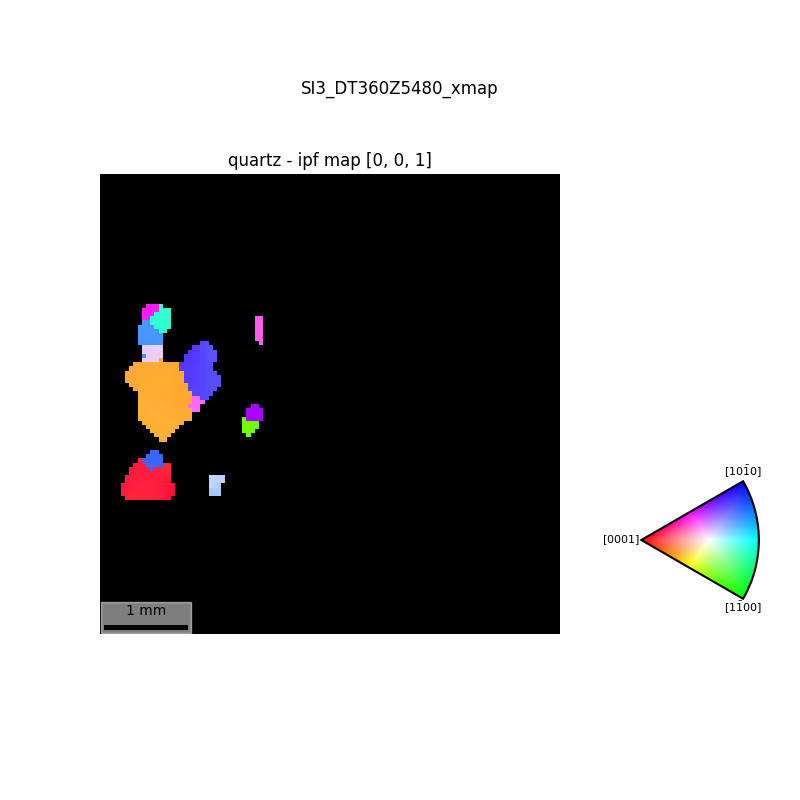

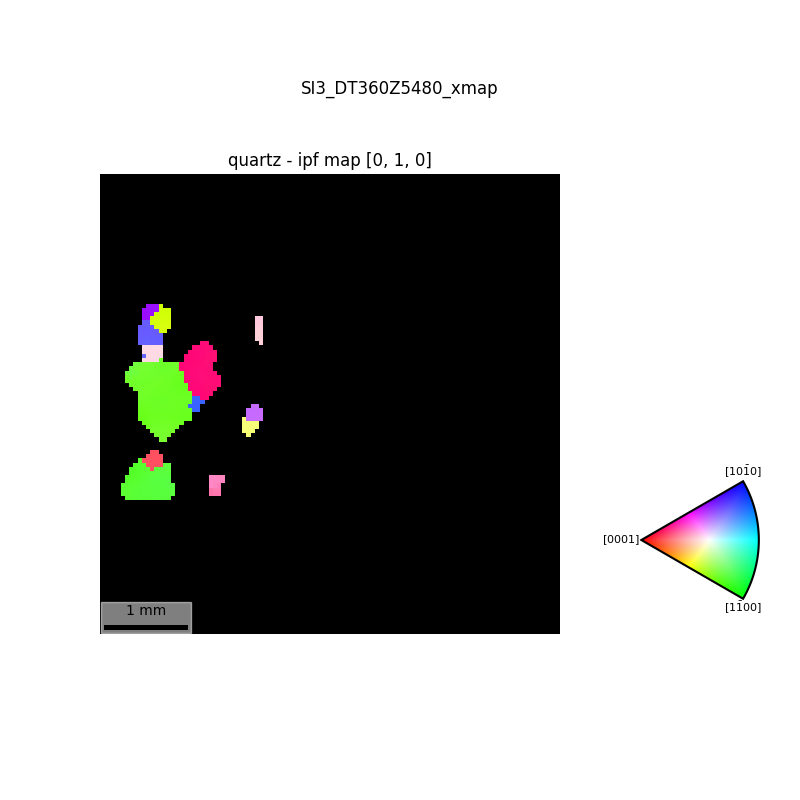

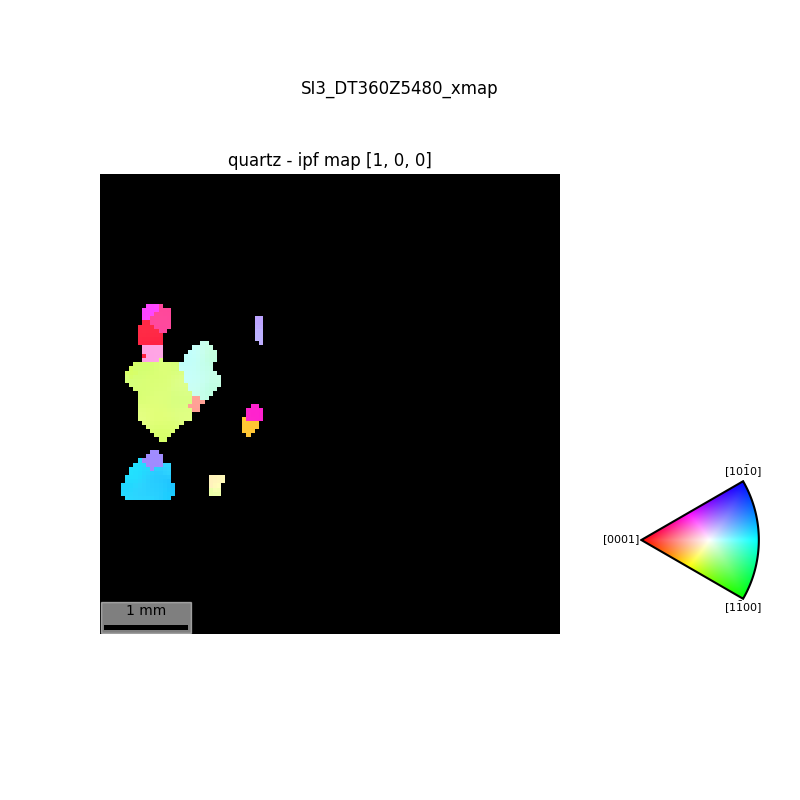

In [28]:
save=False

xmap.plot_ipf_map(pname, ipfdir = [0,0,1], save=save, hide_cbar=False, out=False)
xmap.plot_ipf_map(pname, ipfdir = [0,1,0], save=save, hide_cbar=False, out=False)
xmap.plot_ipf_map(pname, ipfdir = [1,0,0], save=save, hide_cbar=False, out=False)

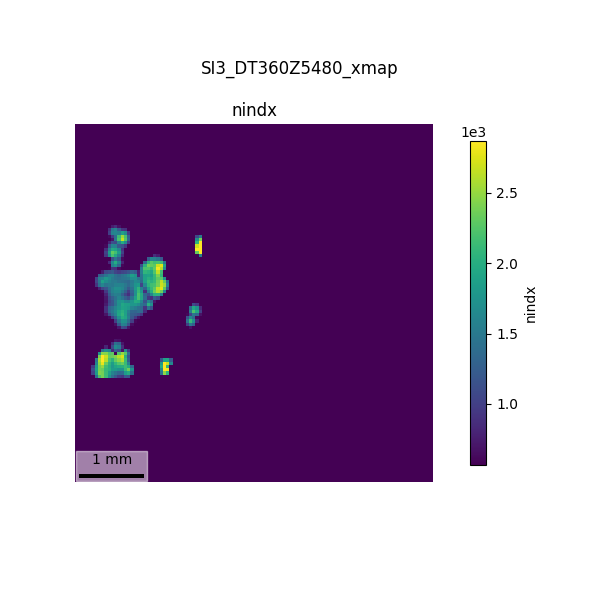

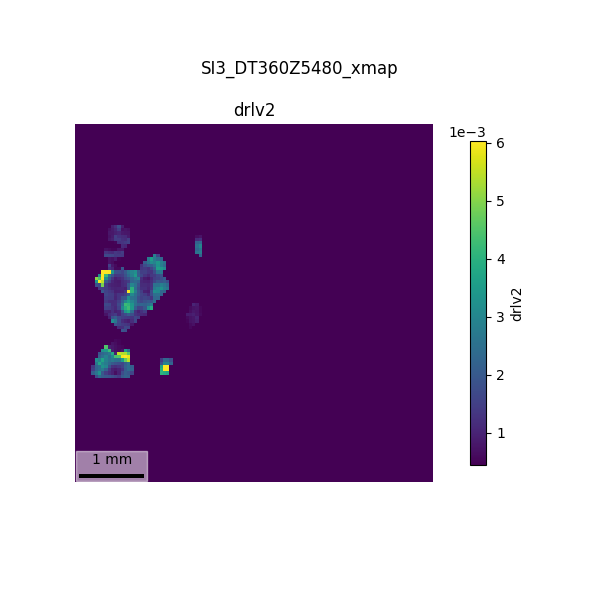

In [29]:
#plot other properties related to indexing
save=False
var_to_plot = ['nindx','drlv2']
kw = {'cmap':'viridis'}

for var in var_to_plot:
    xmap.plot(var, autoscale=True, save=save, **kw)

### Save pixelmap

Don't forget to save indexing results when you are satisfied with the map. There is just the pixelmap to save here, nothing has been added to the peakfile

In [38]:
xmap.save_to_hdf5()

Pixelmap saved to: data/SI3_DT360Z5480_xmap.h5
